# Proyecto: Detección de pérdida de clientes

Imaginemos que trabajamos para una compañía de telecomunicaciones, la cual ofrece servicios de telefonía e internet. La compañía atraviesa por un problema: algunos de los clientes la están abandonando (*churn*). Mencionan que ya no requieren de los servicios y que se irán con un proveedor diferente. A la empresa le gustaría evitar que esto suceda, así que vamos a desarrollar un sistema para identificar a estos clientes y ofrecerles un incentivo para que permanezcan con la compañía. 

<center>
    <figure>
    <img src = "https://www.salesforce.com/mx/blog/wp-content/uploads/sites/11/2023/09/churn-rate.jpg" alt="Proyecto de un sistema de clasificación de clientes potenciales a abandonar los servicios de una empresa." style="width:500px;height:350px;">
    <figcaption> ¿Cómo identificar a clientes que potencialmente podrían abandonar los servicios de  una compañía y qué hacer para evitarlo? </figcaption>
    </figure>
</center>

Tenemos disponible un conjunto de datos donde se ha registrado información sobre los clientes: el tipo de servicio que contrataron, cuánto pagan por él, y qué tanto tiempo han permanecido como clientes. También, disponemos de la información de quiénes han cancelado sus contratos y dejado de utilizar los servicios. 

## Estrategia

 1. Primero, descargamos el conjunto de datos y hacemos una preparación inicial: renombraremos columnas y cambiaremos los valores de las filas para que sean consistentes durante todo el proyecto.

 2. Después, dividiremos los datos en los conjuntos de entrenamiento, validación y prueba.

 3. Como parte del análisis de datos inicial, debemos ver la importancia de las características para identificar cuáles son importantes en nuestros datos.

 4. Transformamos variables categóricas a numéricas para utilizarlas en el modelo.

 5. Finalmente, entrenaremos un modelo de regresión logística.


## Obteniendo los datos

Para este proyecto, utilizamos el conjunto de datos [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) de [Kaggle](https://www.kaggle.com/). De acuerdo con la deescripción, el dataset contiene la siguiente información:

 - Servicios de los clientes: teléfono, múltiples líneas, internet, soporte técnico y servicios adicionales como seguridad online, backup, protección de dispositivos y TV streaming.
 - Información de la cuenta: qué tanto tiempo han sido clientes, tipo de contrato y tipo de método de pago.
 - Cargos: el monto de pago del cliente del mes anterior y en total.
 - Información demográfica: género, edad y si dependen de ellos o tienen pareja.
 - Churn: si/no, el cliente ha dejado la compañía dentro del mes anterior.

El archivo se incluye en la carpeta `data` del repositorio. 

## Preparación inicial de los datos

Comencemos importando las bibliotecas necesarias para desarrollar el proyecto.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Cargamos el dataset.

In [5]:
data = pd.read_csv('data/customer-churn.csv')

data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Veamos la cantidad de datos y columnas que tenemos en el dataframe.

In [6]:
data.shape

(7043, 21)

Tenemos 7043 registros y 21 columnas. Veamos ahora qué columas tenemos y qué significan.

In [7]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Echemos un vistazo a lo que representa cada una y sus posibles valores.

 - `customerID`: el número de ID del cliente.
 - `gender`: masculino/femenino.
 - `SeniorCitizen`: si el cliente es o no un adulto mayor (0/1).
 - `Partner`: si el cliente vive con su pareja o no (yes/no).
 - `Dependents`: si el cliente tiene personas que dependan económicamente de él (yes/no).
 - `tenure`: el número de meses que han pasado desde el inicio del contrato.
 - `PhoneService`: si el cliente tiene o no servicio telefónico (yes/no)
 - `MultipleLines`: si el cliente tiene o no múltiples líneas telefónicas (yes/no/no phone service).
 - `InternetService`: el tipo de servicio de internet (no/fiber/optic).
 - `OnlineSecurity`: si el servicio de seguridad online está activo (yes/no/no internet).
 - `OnlineBackup`: si el servicio de backup está activo (yes/no/no internet).
 - `DeviceProtection`: si el servicio de protección de dispositivos está activo (yes/no/no internet).
 - `TechSupport`: si el cliente cuenta con soporte técnico (yes/no/no internet).
 - `StreamingTV`: si el servicio de streaming TV está activo (yes/no/no internet).
 - `StreamingMovies`: si el servicio de streaming de pelícuas está activo (yes/no/no internet).
 - `Contract`: tipo de contrato (monthly/yearly/two years).
 - `PaperlessBilling`: si la factura es electrónica (yes/no).
 - `PaymentMethod`: método de pago (electronic check, mailed check, bank transfer, credit card).
 - `MonthlyCharges`: la cantidad cobrada mensualmente (numérico).
 - `TotalCharges`: la cantidad cobrada en total (numérico).
 - `Churn`: si el cliente ha cancelado el contrato (yes/no).

 La característica que nos importa más es la última, `Churn`, ya que es la variable objetivo para nuestro modelo, es decir, lo que nos interesa predecir. Notemos que toma dos posibles valores, `yes` si el cliente se fue o `no` si no lo hizo.

 
Ahora, generalmente, cuando Pandas lee un archivo CSV, automáticamente intenta determinar el tipo adecuado de variable para cada columna. Pero en ocasiones no lo hace, así que debemos verificar si el tipo de datos es correcto.


In [8]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Tenemos distintos tipos de variables: `object`, `int64` y `float64`. Las variables tipo `object` suelen referirse a valores string. Por otro lado, los datos tipo `int64` y `float64`, se refieren a variables numéricas, enteros y flotantes de 64 bits.

Es por ello, que tras una inspección visual, notamos que la variable `TotalCharges` es del tipo `object`, pero al ser un monto de dinero, debería ser numérica. En ocasiones esta confusión ocurre porque Pandas infiere que el tipo de dato es `object` debido a que la columna contiene espacios en blanco para representar un valor faltante. 

Podemos corregir esta situación, al convertirla a una columna numérica, con la función de pandas `to_numeric()`. Algo a considerar es que por default, esta función señala una excepción cuando ve datos no numéricos (como los espacios en blanco). Para evitarlo, especificamos el con el argumento `errors = 'coerce'`. Pandas reemplazará los valores no numéricos con un valor `NaN`. 

In [9]:
total_charges = pd.to_numeric(data.TotalCharges, errors = 'coerce')

total_charges

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

Para confirmar que en efecto los datos contenían caracteres no numéricos, podemos utilizar la función `is_null()`de `total_charges` y usarla para referiros a todas las columnas en las que Pandas no pudo transformar la string original.

In [10]:
data[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


Estos son los registros de la dataframe en los que la columna `TotalCharges` tiene espacios en blanco como valores. Ahora, ¿qué hacemos con ellos? Por simplicidad, haremos que los valores sean iguales a 0.

In [11]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors = 'coerce')

data.TotalCharges = data.TotalCharges.fillna(0)

Adicionalmente, notamos que los nombres de la columna no siguen una convención en específico. Algunas inician con minúsculas, otras con mayúsculas, etc. 
Para mantener uniformidad, vamos a hacer que todos los nombres de las columnas estén en minúsculas, y reemplazar cualquier espacio con guiones bajos.

In [12]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

string_cols = list(data.dtypes[data.dtypes == 'object'].index)

for col in string_cols:

    data[col] = data[col].str.lower().str.replace(' ', '_')

In [13]:
data.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


Ahora consideremos la variable objetivo, `churn`.

In [14]:
data.churn

0        no
1        no
2       yes
3        no
4       yes
       ... 
7038     no
7039     no
7040     no
7041    yes
7042     no
Name: churn, Length: 7043, dtype: object

Como mencionamos anteriormente, tiene dos posibles valores, `yes` o `no`. Notemos que se trata de una variable categórica. Para clasificación binaria, todos los modelos generalmente esperan recibir un número, `0` para no y `1` para yes.

Es necesario hacer la conversión numérica.

In [15]:
data.churn = (data.churn == 'yes').astype(int)

data.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int32

Hemos hecho un poco de pre-procesamiento de datos, pero hagamos un par de pruebas con lo que tenemos. En esta ocasión, utilizaremos la librería Scikit-Learn para la división de los conjuntos y para el entrenamiento e implementación del modelo. Primero, importamos el módulo `model_selection` que puede realizar las tareas de dividir los datos. La función que utilizaremos de este módulo se llama `train_test_split`.

In [16]:
from sklearn.model_selection import train_test_split

Una vez que importamos la función, podemos utilizarla. Esta función toma como entrada la `dataframe` que contiene nuestros datos y crea dos nuevos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. La función lo hace mezclando las entradas en el dataset original para posteriormente dividirlo de tal forma que el data test contenga un porcentaje de los datos y el data train el porcentaje restante. 

Probemos con un data train que contenga el 80% de los datos y que el data test el 20% restante.

In [17]:
data_train_full, data_test = train_test_split(data, test_size = 0.2, random_state=42)

<center>
    <figure>
    <img src = "img/train_test_flow.png" style="width:650px;height:375px;">
    <figcaption> El dataset original se mezcla y después se divide de tal forma que el 80% de los datos va al conjunto de entrenamiento y el 20% restante al conjunto de prueba. </figcaption>
    </figure>
</center>

El tercer parámetro de la función `train_test_split()`, `random_state` se utiliza para garantizar que cada vez que corramos el código, la dataframe se divida de la misma forma siempre. 

Veamos cómo se ve el conjunto de entrenamiento.

In [18]:
data_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
2142,4223-bkeor,female,0,no,yes,21,yes,no,dsl,yes,...,yes,no,no,yes,one_year,no,mailed_check,64.85,1336.80,0
1623,6035-riiom,female,0,no,no,54,yes,yes,fiber_optic,no,...,no,no,yes,yes,two_year,yes,bank_transfer_(automatic),97.20,5129.45,0
6074,3797-vtidr,male,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,23.45,23.45,1
1362,2568-brgyx,male,0,no,no,4,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.20,237.95,1
6754,2775-sefee,male,0,no,yes,0,yes,yes,dsl,yes,...,no,yes,no,no,two_year,yes,bank_transfer_(automatic),61.90,0.00,0


Hasta el momento vamos bien, pero sabemos que debemos dividir a los datos en 3 conjuntos: entrenamiento, validación y prueba. La función `train_test_split()` sólo los divide en entrenamiento y prueba. Podemos dividir el conjunto de entrenamiento obtenido usando la misma función para generar el conjunto de validación.

In [19]:
data_train, data_val = train_test_split(data_train_full, test_size=0.33, random_state=69)

Ahora debemos separar a la columna que contiene a la variable objetivo y almacenarla de forma separada a los dataframe de entrenamiento y validación. 

In [20]:
y_train = data_train.churn.values

y_val = data_val.churn.values

In [21]:
del data_train['churn']
del data_val['churn']

Con los dataframe preparados, podemos utilizar el conjunto de entrenamiento para realizar un análisis exploratorio de datos.

## Análisis exploratorio de datos

Primero, veamos si tenemos valores nulos en el dataset.

In [22]:
data_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

Afortunadamente, ninguna columna contiene datos nulos, así que no hay nada más que hacer.

Por otro lado, podemos revisar la distribución de los valores en la variable objetivo. Primero, usamos la función `value_counts()`.

In [23]:
data_train_full.churn.value_counts()

churn
0    4138
1    1496
Name: count, dtype: int64

De los 5634 registros en el primer conjunto de entrenamiento, 4138 no se han ido mientras que 1496 sí, eso significa que alrededor del 27% de los clientes dejaron de utilizar los servicios. Esto representa la probabilidad de que un cliente abandone la compañía, por lo que este número se conoce como *tasa de cancelación de clientes* o *churn rate*.

Existe otra forma de calcular el *churn rate*, y es a través del promedio. 

In [24]:
global_avg = data_train_full.churn.mean()

print(f"Churn rate: {np.round(global_avg,3)}")

Churn rate: 0.266


Bien, regresando a la cantidad de clientes que abandonaron, es notorio que una categoría tiene muchos más elementos que la otra. Esto es un ejemplo de lo que se conoce como *datasets desbalanceados* (*imbalanced*), por lo que decimos que una clase domina a la otra. El opuesto de esta situación es un dataset *balanceado*, donde las clases positivas y negativas se distribuyen equitativamente en todas las observaciones.

Más adelante veremos qué se puede hacer en casos donde el desbalanceo de categorías juega un papel importante en los resultados del modelo.

Por el momento continuaremos con el análisis. Es importante considerar que tanto las variables categóricas como numéricas del conjunto de datos son importantes, pero también son distintas y necesitan un tratamiento diferente. Por lo tanto, vamos a manejarlas de manera separada. Crearemos dos listas: `numerical` y `categorical`. La primera contendrá todas las variables categóricas y la segunda las numéricas, excluyendo la característica `customerid`.

Tambien, hay que recordar que a pesar de que `seniorcitizen` contiene datos numéricos, la consideramos una variable categórica. 

Para hacerlo, en vez de escribir los nombres uno por uno, utilizamos el método de *list comprehension*, el cual nos proporciona una forma concisa y eficiente para crear listas. Utiliza una expresión para generar los elementos de la lista, lo que nos permite que se apliquen operaciones y filtros a los elementos de una secuencia o iterable. Las *list comprehension* muchas veces pueden reemplazar a los ciclos `for` para generar una lista.

La sintaxis básica de una list comprehension es la siguiente:

    list = [expression for item in iterable if condition]

- `expression`: la expresión que produce los elementos de la nueva lista, puede ser cualquier tipo de operación válida en Python, incluyendo la llamada de funciones. Además, la expresión puede depender de la variable item.
- `item`: la variable que toma cada valor del `iterable` en cada iteración.
- `iterable`: secuencia o colección sobre la que se itera, puede ser una lista, un rango, una string, etc.
- `condition` (opcional): una condición que filtra los elementos del `iterable`, por lo que sólo se incluirán en la nueva lista los elementos para los que la condición sea verdadera.

Ejemplo: Crear una lista de los cuadrados de los números del 0 al 9:

In [25]:
squares = [x**2 for x in range(10)]

print(squares)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


El ciclo `for` correspondiente sería:

In [26]:
sq = []

for x in range(10):

    sq.append(x**2)

print(sq)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


Ejemplo: Filtrar números impares del 0 al 9 y calcular sus cubos:

In [27]:
cubic_odds = [x**3 for x in range(10) if x % 2 == 1]

print(cubic_odds)

[1, 27, 125, 343, 729]


Entonces, creamos las listas `categorical` y `numerical` con list comprehension así:

In [28]:
categorical = []

numerical = []

categorical = [col for col in data_train_full.columns if data_train_full[col].dtype == 'object'] # Filtramos las columas cuyo dtype sea `object`

numerical = [col for col in data_train_full.columns if data_train_full[col].dtype in ['float64', 'int64'] and col != 'seniorcitizen'] # Filtramos las columnas cuyo dtype sea `float64` o `int64` excluyendo a seniorcitizen

categorical = [col for col in categorical if col != 'customerid'] + ['seniorcitizen'] # añadimos `seniorcitizen` a la lista de categóricas

numerical = [col for col in numerical if col!= 'customerid'] # excluimos la columna `customerid` de la lista numérica

print('Columnas categóricas: ', categorical)
print('Columnas numéricas: ', numerical)

Columnas categóricas:  ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen']
Columnas numéricas:  ['tenure', 'monthlycharges', 'totalcharges']


Ahora, podemos ver cuántos valores únicos tiene cada columna.

In [29]:
data_train_full[categorical].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

La mayoría de las columnas categóricas tienen entre 2 y 3 categorías. Ahora tenemos que hacer otra parte importante del análisis exploratorio de datos: entender cuáles características podrían ser importantes para el modelo. 

## Feature importance

El saber cómo el resto de las variables afecta a la variable objetivo, `churn`, es fundamental para entender los datos y construir un buen modelo. Este proceso se conoce como `feature importance analysis` y generalmente se hace como parte del análisis exploratorio de datos para averiguar qué variables nos serán útiles. También, nos da perspectivas adicionales acerca del conjunto de datos y nos ayudará a responder preguntas como "¿Qué hace que los clientes abandonen los servicios de la empresa?" y, "¿qué características comparten la gente que abandona?".

Comencemos con las variables categóricas. Lo primero que podemos hacer es ver el churn rate para cada variable. Sabemos que para cada variable, hay un grupo de clientes que comparten ese valor. Para cada grupo, podemos calcular el churn rate, que corresponderá al valor de ese grupo. Cuando lo tengamos, podemos compararlo con el churn rate global.

Si la diferencia entre estas tasas es pequeña, el valor no es importante al momento de predecir la tasa de abandono porque este grupo de clientes no es muy diferente del resto. Por otro lado, si la diferencia es considerable, algo dentro de ese grupo los separa del resto. Un modelo de machine learning debería ser capaz de identificar esto y usarlo para generar predicciones.

Veamos primero la variable `gender`. La cual puede tomar dos valores, `female` y `male`. Por lo tanto hay dos grupos de clientes, aquellos para los cuales se cumple `gender == female` y para los que se cumple `gender == male`. 

Calculemos entonces el churn rate para cada grupo.

In [30]:
female_mean = data_train_full[data_train_full.gender == 'female'].churn.mean()

print(f"El churn rate para el grupo femenino es de: {np.round(female_mean, 3)}")

El churn rate para el grupo femenino es de: 0.271


In [31]:
male_mean = data_train_full[data_train_full.gender == 'male'].churn.mean()

print(f"El churn rate para el grupo masculino es de: {np.round(male_mean, 3)}")

El churn rate para el grupo masculino es de: 0.26


In [32]:
print(f"Churn rate global: {np.round(global_avg,3)}")

Churn rate global: 0.266


Resulta que el churn rate de las clientas es de alrededor del 27.7%, mientras que el de los clientes es de alrededor del 26%. Recordemos que el churn rate global es del 27%. 
Por lo tanto, la diferencia entre las tasas de ambos grupos es pequeña, lo que nos indica que conocer el género del cliente no nos ayuda a identificar si abandonarán los servicios de la compañía o no.

Intentemos con otra variable: `partner`. Esta toma los valores `yes` o `no`.

In [33]:
partner_yes = data_train_full[data_train_full.partner == 'yes'].churn.mean()

partner_no = data_train_full[data_train_full.partner == 'no'].churn.mean()

print(f"El churn rate para partner = yes es de: {np.round(partner_yes, 3)}")
print(f"El churn rate para partner = no es de: {np.round(partner_no, 3)}")
print(f"Churn rate global: {np.round(global_avg,3)}")

El churn rate para partner = yes es de: 0.201
El churn rate para partner = no es de: 0.326
Churn rate global: 0.266


En este caso, los clientes que indicaron tener pareja tienen un menor churn rate que aquellos que no la tienen. Es decir, es más probable que los clientes sin pareja abandonen la compañía.

## Risk ratio

Además de ver la diferencia entre la tasa grupal y la tasa global, resulta interesante mirar la razón entre ellas. En estadística, la razón entre las proabilidades en distintos grupos se conoce como *riesgo relativo* (*razón de riesgo* o *risk ratio*), donde el *riesgo* se refiere al riesgo de tener el efecto. En nuestro caso, el efecto es el churn, así que tenemos:

$$ \text{risk} = \frac{\text{tasa grupal}}{\text{tasa global}} $$

Entonces para `gender == female` tenemos:

In [34]:
risk_gender_female = female_mean / global_avg

print(round(risk_gender_female,3))

1.02


El riesgo es un número entre 0 e infinito. Se interpreta como qué tan plausible es que los elementos del grupo sufran del efecto comparado con la población total. Si la diferencia entre la tasa grupal y la global es pequeña, el riesgo es cercano a 1: el grupo tiene el mismo nivel de riesgo como el resto de la población. Un grupo con un riesgo cercano a 1 no es riesgoso en absoluto.

Si el riesgo es menor a 1, el grupo tiene menores riesgos, ya que la tasa grupal es menor a la global. Por otro lado, si el valor es mayor a 1, el grupo es riesgoso: hay más churn en el grupo que en la población. Por lo que un riesgo de, por ejemplo, 2 significa que los clientes de dicho grupo son 2 veces más probables a abandonar.

Ahora calculemos los riesgos para `gender == male` y creamos un dataframe que almacene la información calculada.

In [35]:
data_group = data_train_full.groupby(by = 'gender').churn.agg(['mean']) # Agrupamos a partir de data_train_full por género y agregamos la columna 'mean'

data_group['diff'] = data_group['mean'] - global_avg # Creamos la columna diferencia que calcula la diferencia entre la tasa grupal y la global para cada categoria

data_group['risk'] = data_group['mean'] / global_avg # Creamos la columna risk que calcula el riesgo para cada grupo

data_group

,mean,diff,risk
gender,,,
female,0.270841,0.005310,1.019998
male,0.260478,-0.005053,0.980971


Ahora repitamos esto para cada variable categórica.

In [36]:
from IPython.display import display # Para ver los dataframes generados en cada iteración se utiliza la función display del módulo display de IPython

for col in categorical:

    data_group = data_train_full.groupby(by = col).churn.agg(['mean'])

    data_group['diff'] = data_group['mean'] - global_avg

    data_group['risk'] = data_group['mean'] / global_avg

    display(data_group)

,mean,diff,risk
gender,,,
female,0.270841,0.005310,1.019998
male,0.260478,-0.005053,0.980971


,mean,diff,risk
partner,,,
no,0.326446,0.060916,1.229411
yes,0.200733,-0.064798,0.755968


,mean,diff,risk
dependents,,,
no,0.312326,0.046795,1.176233
yes,0.155674,-0.109856,0.586276


,mean,diff,risk
phoneservice,,,
no,0.253623,-0.011908,0.955156
yes,0.266824,0.001293,1.004871


,mean,diff,risk
multiplelines,,,
no,0.251397,-0.014134,0.946771
no_phone_service,0.253623,-0.011908,0.955156
yes,0.284105,0.018574,1.069952


,mean,diff,risk
internetservice,,,
dsl,0.191851,-0.073679,0.722521
fiber_optic,0.415558,0.150028,1.565010
no,0.076606,-0.188924,0.288502


,mean,diff,risk
onlinesecurity,,,
no,0.416014,0.150484,1.566727
no_internet_service,0.076606,-0.188924,0.288502
yes,0.145342,-0.120189,0.547363


,mean,diff,risk
onlinebackup,,,
no,0.398693,0.133162,1.501494
no_internet_service,0.076606,-0.188924,0.288502
yes,0.216531,-0.048999,0.815467


,mean,diff,risk
deviceprotection,,,
no,0.387706,0.122175,1.460117
no_internet_service,0.076606,-0.188924,0.288502
yes,0.226825,-0.038705,0.854234


,mean,diff,risk
techsupport,,,
no,0.413472,0.147941,1.557153
no_internet_service,0.076606,-0.188924,0.288502
yes,0.152855,-0.112676,0.575657


,mean,diff,risk
streamingtv,,,
no,0.335418,0.069887,1.263197
no_internet_service,0.076606,-0.188924,0.288502
yes,0.298945,0.033415,1.125841


,mean,diff,risk
streamingmovies,,,
no,0.333333,0.067803,1.255348
no_internet_service,0.076606,-0.188924,0.288502
yes,0.301320,0.035789,1.134784


,mean,diff,risk
contract,,,
month-to-month,0.426533,0.161002,1.606340
one_year,0.117987,-0.147544,0.444343
two_year,0.028379,-0.237151,0.106878


,mean,diff,risk
paperlessbilling,,,
no,0.16414,-0.101390,0.618159
yes,0.33594,0.070409,1.265164


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.174475,-0.091056,0.657080
credit_card_(automatic),0.152404,-0.113126,0.573961
electronic_check,0.449921,0.184390,1.694420
mailed_check,0.190328,-0.075203,0.716782


,mean,diff,risk
seniorcitizen,,,
0,0.237098,-0.028433,0.892922
1,0.413907,0.148377,1.558793


Entonces, a partir de los resultados tenemos lo siguiente:

 - Para `gender`: no hay diferencia considerable entre las dos categorías. Sus medias son similares y para ambos grupos, los riesgos son cercanos a 1.
 - Para `partner`: los clientes con pareja abandonan menos que los que no tienen pareja. Sus riesgos son de **0.75** y **1.22**, respectivamente.
 - Para `dependents`: los clientes sin dependientes económicos son más propensos a abandonar que los que los tienen. Sus riesgos son de **1.17** y **0.58**.
 - Para `phoneservice`: los clientes que usan el servicio telefónico no están en riesgo de abandonar: su riesgo es cercano a **1**. Los que no usan servicio telefónico son menos propensos a abandonar, su riesgo es < 1 y la diferencia con la tasa global es negativa.
 - etc.

Esta revisión 1 a 1 es tediosa. Vamos a utilizar el mismo código que genera las dataframe de diferencias y riesgos para cada variable categórica pero vamos a graficar la información de la columna `risk` para cada categoría, con la intención de visualizar qué valores de cada categoría presentan un mayor riesgo de abandonar.

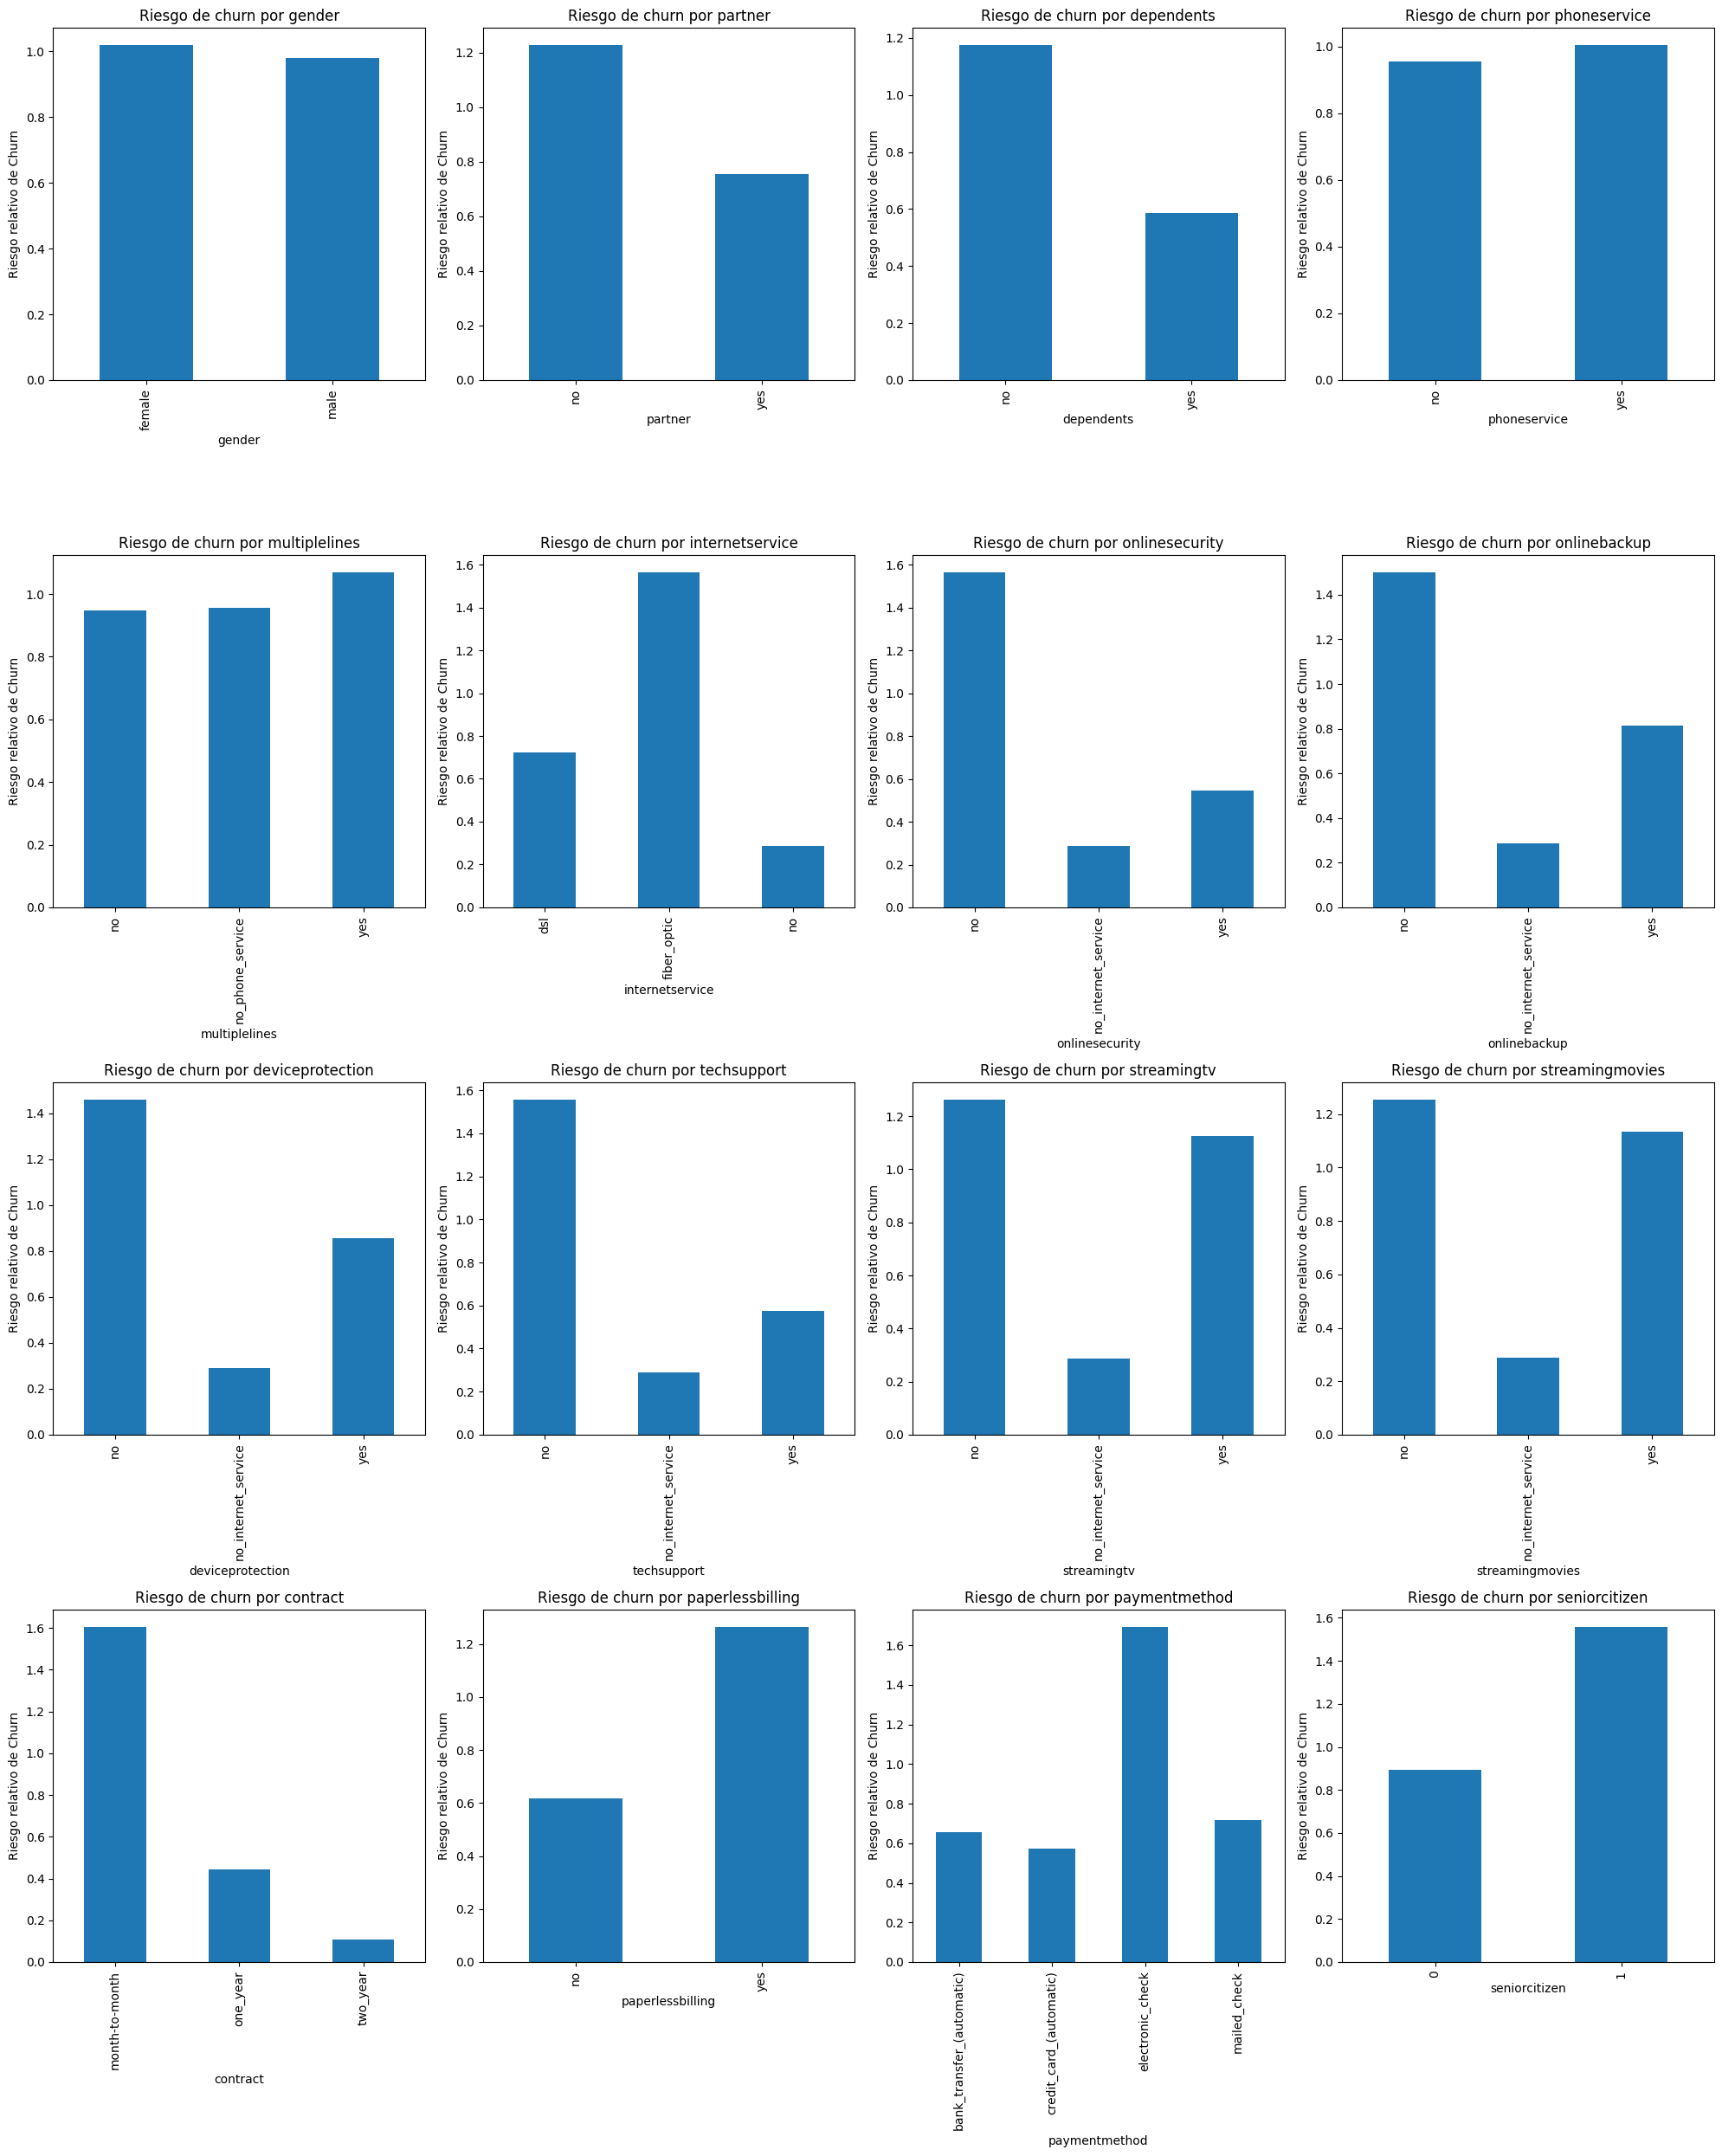

In [37]:
n_categories = len(categorical)

n_cols = 4

n_rows = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (20, 25)) 


for i, col in enumerate(categorical):

    ax = axes[i // n_cols, i%n_cols] if n_rows > 1 else axes[i] # Encuentra el índice del subplot actual

    data_group = data_train_full.groupby(by = col).churn.agg(['mean'])

    data_group['diff'] = data_group['mean'] - global_avg

    data_group['risk'] = data_group['mean'] / global_avg

    data_group['risk'].plot(kind = 'bar', ax = ax)

    ax.set_title(f'Riesgo de churn por {col}') # Dibujamos el gráfico de barras en el eje actual
    ax.set_xlabel(col)
    ax.set_ylabel('Riesgo relativo de Churn')


fig.tight_layout() # Ajustamos cada figura para mejor visualización

plt.show() # Muestra la figura completa con todos los subgráficos




De los gráficos podemos identificar dos variables con diferencias significativas:

 - Para `techsupport`: los clientes que no cuentan con el servicio de soporte técnico tienden a abandonar más que los que si lo tienen.
 - Para `contract`: los clientes con un contrato mes a mes son más propensos a abandonar que aquellos con contratos anuales y bianuales.
 - Para `paymentmethod`: los clientes que pagan con cheques electrónicos tienden a abandonar más que el resto de los métodos de pago.


De esta forma, al observar las diferencias y los riesgos, podemos identificar las características que resultarán más beneficiosas para detectar el churn. Por lo que esperamos que estas características sean más útiles para los modelos que construyamos.

## Mutual information

Las diferencias que exploramos son útiles para nuestro análisis e importantes para entender los datos, pero es difícil usarlas para decir cuál es la característica más importante y si `techsupport`es más importante que `contract``. 

Afortunadamente, las métricas de importancia nos pueden ayudar: podemos medir el grado de dependencia entre una variable categórica y la variable objetivo. Si dos variables son dependientes, conocer el valor de una nos da información sobre la otra. Por otro lado, si una variable es completamente independiente de la objetivo, no es útil y podemos removerla con seguridad.

Para variables categóricas, se puede emplear la métrica de *mutual information* (*información mutua*), que nos dice cuánta información aprendemos sobre una variable si aprendemos el valor de la otra. Es un concepto de teoría de la información, y aplicada en machine learning, a menudo se usa para medir la dependencia mutua entre dos variables.

Valores mayores de mutual information significan un mayor grado de dependencia, en cambio, un valor menor de mutual information indica que la variable categórica y la variable objetivo son independientes.

Mutual information ya está implementada en la función `mutual_info_score` del módulo `metrics`de Scikit-Learn:

In [38]:
from sklearn.metrics import mutual_info_score

Crearemos una función que calcule la información mutua entre la variable categórica y la variable objetivo.

In [39]:
def m_i(series):

    return mutual_info_score(series, data_train_full.churn)

Ahora aplicamos la función para las variables categóricas en el dataset original. Después, ordenamos los valores del resultado.

In [40]:
data_mi = data_train_full[categorical].apply(m_i)

data_mi = data_mi.sort_values(ascending =False).to_frame(name ='MI')

data_mi

,MI
contract,0.096652
onlinesecurity,0.063393
techsupport,0.060935
internetservice,0.053313
onlinebackup,0.045424
paymentmethod,0.042861
deviceprotection,0.042007
streamingtv,0.030844
streamingmovies,0.030705
paperlessbilling,0.019077


Notemos que `contract`, `onlinesecurity` y `techsupport` son las características más importantes. Lo cual es una confirmación del resultado calculado por la razón de riesgo. De la misma forma que `gender` figura como una de las características menos importantes. 

## Coeficiente de correlación

La información mutua es una manera de cuantificar el grado de dependencia entre dos variables categóricas, pero no funciona cuando una de las características es numérica. Para medir la dependencia entre una variable objetivo binaria y una numérica, podemos suponer que la variable binaria es numérica y utilizar los métodos clásicos de estadística para buscar dependencia entre las variables.

Uno de esos métodos es el *coeficiente de correlación* (también conocido como *coeficiente de Pearson*), el cual es un valor numérico entre -1 y 1:

 - Una *correlación positiva* significa que cuando una variable aumenta, la otra también. En el caso de un objetivo binario, cuando los valores de la variable sean altos, veremos más unos que ceros. Cuando los valores de la variable sean bajos, los ceros serán más frecuentes.
 - Una *correlación cero* significa que no hay relación entre las dos variables, son completamente independientes.
 - Una *correlación negativa* ocurre cuando una variable aumenta y la otra disminuye. Para el caso binario, si los valores son altos, veremos más ceros que unos en el objetivo. Cuando los valores sean bajos veremos más unos.

Podemos calcular el coeficiente de correlación en Pandas con la función `corrwith(series)`.

In [41]:
data_train_full[numerical].corrwith(data_train_full.churn)

tenure           -0.344925
monthlycharges    0.188574
totalcharges     -0.193370
dtype: float64

Los resultados indican:

 - La correlación entre `tenure` y `churn` es de **-0.35**, al ser negativo, mientras más tiempo permanezcan como clientes, tienen menor tendencia a abandonar los servicios.
 - La correlación entre `monthlycharges` y `churn`es de **0.19**, es positiva por lo que los clientes que pagan más tienden a abandonar más a menudo.
 - La correlación entre `totalcharges`y `churn` es de **-0.19**, una correlación negativa: mientras más tiempo permancen los clientes en la compañía más pagan en total, así que es menos probable que abandonen. 

 Veamoslo gráficamente.

C:\Users\Francisco Valerio\AppData\Local\Temp\ipykernel_19964\3925780466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn_rate = data_train_full.groupby('tenure_group')['churn'].mean()*100
C:\Users\Francisco Valerio\AppData\Local\Temp\ipykernel_19964\3925780466.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_charges_churn_rate = data_train_full.groupby('monthly_group')['churn'].mean()*100


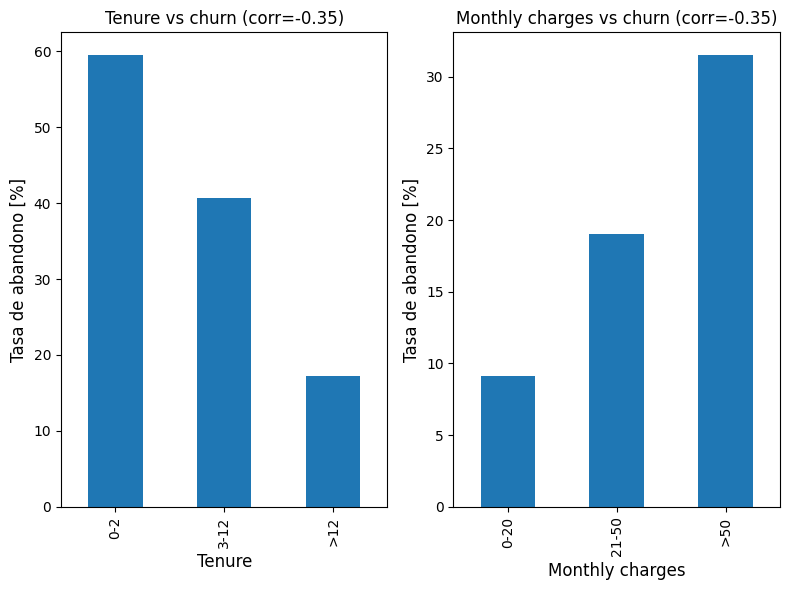

In [42]:
data_train_full['tenure_group'] = pd.cut(data_train_full['tenure'], bins = [0, 2, 12, np.inf], labels = ['0-2', '3-12', '>12'])

data_train_full['monthly_group'] = pd.cut(data_train_full['monthlycharges'], bins = [0, 20, 50, np.inf], labels = ['0-20', '21-50', '>50'])

tenure_churn_rate = data_train_full.groupby('tenure_group')['churn'].mean()*100

monthly_charges_churn_rate = data_train_full.groupby('monthly_group')['churn'].mean()*100


tenure_corr = data_train_full.tenure.corr(data_train_full.churn)

monthly_corr = data_train_full.monthlycharges.corr(data_train_full.churn)


fig, axes = plt.subplots(1, 2 , figsize = (8,6))


tenure_churn_rate.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Tenure', fontsize = 12)
axes[0].set_ylabel('Tasa de abandono [%]', fontsize = 12)
axes[0].set_title('Tenure vs churn (corr=-0.35)')


monthly_charges_churn_rate.plot(kind = 'bar', ax = axes[1])
axes[1].set_xlabel('Monthly charges', fontsize = 12)
axes[1].set_ylabel('Tasa de abandono [%]', fontsize = 12)
axes[1].set_title('Monthly charges vs churn (corr=-0.35)')

plt.tight_layout()
plt.show()



## Feature engineering

Una vez que identificamos las variables que podrían ser útiles para el modelo, necesitamos realizar feature engineering para transformar las variables categóricas a valores numéricos. 
Utilizaremos un *one-hot encoding*, por ejemplo, la variable `contract` tiene como posibles valores *monthly*, *yearly* y *two-year*. Si un cliente tiene un contrato anual, lo podemos representar como `(0,1,0)`. 

Consideremos primero un caso donde tenemos sólo las variables `gender` y `contract`, veamos cómo crear una matriz con estas variables.

Ya que `gender` tiene dos posibles valores, podemos crear 2 columnas en la matriz resultante. Por otro lado, la variable `contract` tiene tres posibles valores, por lo que añadimos 3 columnas y obtenemos una matriz con 5 columnas.

Pensemos en que tenemos dos clientes:

 - Una cliente con un contrato anual
 - Un cliente con un contrato mensual.

 Tenemos entonces:


<center>
    <figure>
    <img src = "img/one-hot.png"  style="width:703px;height:295px;">
    <figcaption> One-hot encoding para dos variables. </figcaption>
    </figure>
</center>

Este caso hipotético, con 2 clientes y 2 características es sencillo, pero recordemos que tenemos más de 7000 registros y más de 20 características, así que hacerlo a mano es impensable. Por fortuna, podemos usar nuevamente Scikit-Learn. Utilizaremos la función `DictVectorizer`.

Como su nombre lo dice, la función toma como entrada un diccionario y lo *vectoriza*, es decir crea vectores a partir de él. Después, los vectores se juntan como las columnas de una matriz y dicha matriz puede utilizarse como entrada para un modelo de machine learning. El flujo de este procedimiento se ilustra a continuación.

<center>
    <figure>
    <img src = "img/model_flow.png"  style="width:900px;height:315px;">
    <figcaption> El proceso para crear un modelo. </figcaption>
    </figure>
</center>

Primero, debemos convertir la dataframe a una lista de diccionarios, Pandas nos permite hacerlo fácilmente con la función `to_dict()` asegúrandonos de pasar el parámetro `orient = "records"`

In [43]:
train_dict = data_train[categorical + numerical].to_dict(orient = 'records')

El primer elemento de esta nueva lista se ve así:

In [44]:
train_dict[0]

{'gender': 'female',
 'partner': 'no',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'no',
 'onlinebackup': 'no',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'no',
 'streamingmovies': 'no',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'seniorcitizen': 0,
 'tenure': 1,
 'monthlycharges': 45.3,
 'totalcharges': 45.3}

Cada columna del dataframe es una clave en este diccionario.  Ahora, utilizamos `DictVectorizer`. Primero hay que crear una instancia que contendrá la lista de diccionarios. Incluimos el parámetro `sparse = False` para indicar que no tendremos una matriz dispersa y que cree un array de NumPy. 

Después utilizamos el método `fit` sobre la instancia para que mapee el contenido de los diccionarios a la matriz.

In [45]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)

dv.fit(train_dict)

DictVectorizer(sparse=False)

Una vez que ajustamos los vectores, podemos utilizarlo para convertir los diccionarios a una matriz utilizando el método `transform`.

In [46]:
X_train = dv.transform(train_dict)

Esto genera una matriz con 45 columnas. Veamos la primera fila, que corresponde al cliente que vimos en el diccionario.

In [47]:
X_train[0]

array([ 1. ,  0. ,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  1. ,
        0. ,  0. , 45.3,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,
        0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,
        0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,
       45.3])

Para no perdernos, podemos ver los nombres de las columnas que representan con el método `get_feature_names_out()`.

In [48]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

Notemos que para cada columna categórica, se han creado múltiples columnas para cada uno de los posibles valores. Para `contract` tenemos `contract=month-to-month`, `contract=one_year`, `contract=two_year` y para `dependents` tenemos `dependents=no`, `dependents=yes. También hay que notar que por ejemplo `tenure` o `totalcharges` mantienen su nombre porque son numéricas.

Ahora, podemos entrenar.

## Regresión logística

Para nuestro modelo de clasificación, utilizaremos una *regresión logística*, la cual es similar a la *regresión linear*. Recordemos que un modelo de regresión lineal es un modelo que puede predecir un número. Tiene la forma:

$$ g(x_i) = w_0 + x_{i}^T w $$

- $x_i$ es el vector de características correspondiente a la $i$-ésima observación.
- $w_0$ es el valor umbral.
- $w$ es un vector con los pesos del modelo.

Un modelo de regresión lineal se entrena para predecir la variable objetivo $y_i$. 

Por otro lado, la regresión logística también es un modelo lineal, pero a diferencia del primero, es un modelo de clasificación, no de regresión. Es un modelo de clasificación binaria, así que la variable objetivo, $y_i$, es binaria. Las observaciones donde $y_i =1$ se conocen como *ejemplos positivos*: son los ejemplos en los que el efecto que queremos predecir está presente. Mientras que las observaciones donde $y_i = 0$ son *ejemplos negativos*. En nuestro proyecto, $y_i = 1$ significa que el cliente abandonó y $y_i = 0$ lo opuesto. 

La salida de una regresión logística es una **probabilidad**, la probabilidad de que la observación $x_i$ sea positiva, o que $y_i =1$. En nuestro caso, es la probabilidad de que el $i$-ésimo cliente abandone.

Para ser capaces de considerar a la salida como una probabilidad, necesitamos asegurarnos de que las predicciones del modelo estén siempre entre 0 y 1. Usamos entonces la función *sigmoide* (o *logística*), la cual se define como:

$$\sigma(x) = \frac{1}{1 + \exp(-x)} $$

Veamos cómo se comporta esta función.

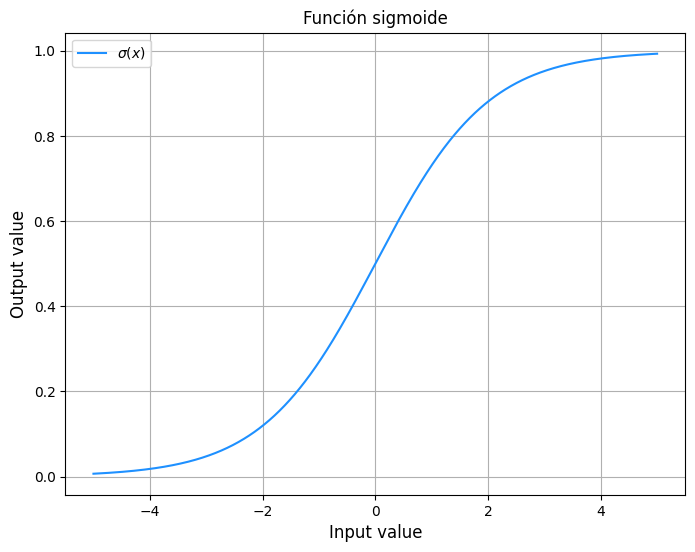

In [49]:
def sigmoid(x):

    return 1/(1 + np.exp(-x))

a = np.linspace(-5,5,1000)

fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(a, sigmoid(a), color = 'dodgerblue', label = r'$\sigma(x)$')
ax.set_xlabel('Input value', fontsize = 12)
ax.set_ylabel('Output value', fontsize = 12)
ax.set_title('Función sigmoide', fontsize = 12)
ax.grid()
ax.legend()
plt.show()

Entonces, el modelo de regresión logística se expresa como: 

$$ g(x_i) = \sigma(w_0 + x_{i}^T w) $$

Considerando que $x_i$ es $n$-dimensional, tenemos:

$$ 
\begin{split}
& g(x_i) = \sigma \left(  w_0 + x_{i1} w_1 + x_{i2} w_2 + \dots + w_{in} w_n \right) \\
\to \quad & g(x_i)= \sigma \left( w_0 + \sum_{j=1}^n x_{ij} w_j \right) \\

\end{split} $$

Los parámetros del modelo de regresión logística son los mismos que de la regresión lineal:

- $w_0$ es el término umbral
- $w = (w_1, w_2, ..., w_n)$ es el vector de pesos. 

Para aprender los pesos, necesitamos entrenar el modelo. Usando Scikit-Learn, importamos el módulo `LogisticRegression`.

In [50]:
from sklearn.linear_model import LogisticRegression

Después, entrenamos al llamar al método `fit`. Primero, creamos el modelo y usaremos dos de los parámetros de este método: `solver` y `random_state`. `solver` corresponde al algoritmo utilizado, mientras que `random_state` es el número semilla para el generador de pseudo-aleatorios. Mezcla los datos al entrenar el modelo y nos garantiza reproducibilidad.

Posteriormente, entrenamos el modelo con los datos de entrenamiento (observaciones y objetivo).

In [51]:
model = LogisticRegression(solver = 'liblinear', random_state=42)

In [52]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Una vez que se ha entrenado, veamos cómo se desempeña para hacer predicciones. Podemos utilizar nuestros datos de validación para obtener la probabilidad de abandono para cada cliente en ese conjunto. 

Para hacerlo, necesitamos aplicar el esquema de *one-hot encoding* a todas las variables categóricas.

In [53]:
val_dict = data_val[categorical + numerical].to_dict(orient = 'records')

X_val = dv.transform(val_dict)

Después usamos esta matriz como entrada del método `predict_proba` del modelo.

In [54]:
y_pred = model.predict_proba(X_val)

y_pred	

array([[0.40469268, 0.59530732],
       [0.38609054, 0.61390946],
       [0.6613088 , 0.3386912 ],
       ...,
       [0.983256  , 0.016744  ],
       [0.31596796, 0.68403204],
       [0.8932025 , 0.1067975 ]])

El resultado es un array de NumPy de dos dimensiones. La primera columna contiene la probabilidad de que el objetivo sea negativo (no churn) y la segunda contiene la probabilidad de que sea positivo (churn).

Ya que la información puede ser redundante y confusa, sólo nos importan los clientes que estén en riesgo de abandonar los servicios de la compañía, es decir, sólo nos importa la segunda columna. Hagamos un slice y quedémonos sólo con esa información.

In [55]:
y_pred = model.predict_proba(X_val)[:,1]

y_pred

array([0.59530732, 0.61390946, 0.3386912 , ..., 0.016744  , 0.68403204,
       0.1067975 ])

Este resultado (las probabilidades) se conocen a menudo como *soft predictions*. Nos dicen que la probabilidad de abandono está entre 0 y 1, y queda a nuestro criterio cómo interpretar dichos números y cómo usarlos.

Recordemos que el objetivo de crear este modelo es que queremos retener a los clientes al identificar a aquellos que están a punto de cancelar sus contratos y enviarles mensajes promocionales, ofreciendo descuentos y otros benificios, con la esperanza de que al recibir el beneficio decidan quedarse.

Para tomar esa decisión, necesitamos *hard predictions*, valores binarios de `True` (churn, enviar email) o `False` (not churn, no enviar email). Para obtener las predicciones binarias, tomamos las probabilidades y establecemos una cota. Si la probabilidad del cliente es mayor que la cota, entonces predecimos abandono. 

Pongamos **0.5** como nuestra cota. Podemos filtrar a aquellos valores del vector `y_pred` que cumplan con esta condición. Los elementos del array serán comparados uno a uno con la condición y el resultado será un array con valores booleanos.

In [56]:
churn = y_pred >= 0.5

churn

array([ True,  True, False, ..., False,  True, False])

Ahora que tenemos las *hard predictions* nos gustaría saber qué tan buenas son, así que debemos evaluar la calidad de las predicciones. La forma más sencilla de hacerlo es tomar cada predicción y compararla con el valor real. Esta medida se conoce como *accuracy*, y es sencilla de calcular:

In [57]:
print("Accuracy: ", np.round((y_val == churn).mean(),2))

Accuracy:  0.79


Obtuvimos un valor de accuracy del 0.79, esto significa que las predicciones del modelo igualaron los valores reales un 79% de las veces, el modelo hace predicciones correctas el 79% de los casos. 

Ahora que sabemos cómo entrenar un modelo y evaluar su precisión, intentaremos profundizar un poco sobre el modelo y ver cómo podemos interpretar los coeficientes que aprendió.


## Interpretación del modelo

Sabemos que el modelo de regresión logística tiene 2 parámetros que aprende de los datos:

- $w_0$ es el término umbral
- $w = (w_1, w_2, ..., w_n)$ es el vector de pesos.

Podemos recuperar el término umbral a partir del modelo entrenado:

In [58]:
model.intercept_[0]

-0.12672559969565078

Entonces, $w_0 = -0.12$. El resto de los pesos se obtiene como:

In [59]:
model.coef_[0]

array([ 5.36745468e-01, -1.46293687e-01, -5.17177380e-01,  3.06062780e-02,
       -1.57331878e-01,  3.95331997e-02, -1.11445229e-01, -5.48135701e-02,
       -2.70708808e-02, -9.96547189e-02, -3.80192487e-01,  3.64912117e-01,
       -1.11445229e-01,  1.52145869e-03, -2.63204689e-01,  1.66452355e-01,
       -2.99732652e-02,  9.14510937e-02, -1.11445229e-01, -1.06731464e-01,
        2.50083758e-01, -1.11445229e-01, -2.65364129e-01, -2.28383732e-01,
        1.01658132e-01, -9.48261098e-02, -3.18994899e-02, -8.07526337e-02,
       -1.87051199e-01,  2.76638832e-01, -1.35560598e-01,  1.66452355e-01,
       -2.93177954e-01,  1.74002371e-01, -2.35434899e-02, -1.11445229e-01,
        8.26311955e-03, -1.48865425e-01, -1.11445229e-01,  1.33585054e-01,
        2.27222209e-01, -1.11445229e-01, -2.42502579e-01, -6.85573033e-02,
        4.00836860e-04])

Obtenemos un montón de números correspondientes a $w_1$, $w_2$, etc. Para entender cómo cada característica se asocia a cada peso, utilizaremos el método `get_feature_names_out()` de la clase `DictVectorizer`. Podemos unir los nombres con los coeficientes usando la función `zip()`.

In [60]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.537,
 'contract=one_year': -0.146,
 'contract=two_year': -0.517,
 'dependents=no': 0.031,
 'dependents=yes': -0.157,
 'deviceprotection=no': 0.04,
 'deviceprotection=no_internet_service': -0.111,
 'deviceprotection=yes': -0.055,
 'gender=female': -0.027,
 'gender=male': -0.1,
 'internetservice=dsl': -0.38,
 'internetservice=fiber_optic': 0.365,
 'internetservice=no': -0.111,
 'monthlycharges': 0.002,
 'multiplelines=no': -0.263,
 'multiplelines=no_phone_service': 0.166,
 'multiplelines=yes': -0.03,
 'onlinebackup=no': 0.091,
 'onlinebackup=no_internet_service': -0.111,
 'onlinebackup=yes': -0.107,
 'onlinesecurity=no': 0.25,
 'onlinesecurity=no_internet_service': -0.111,
 'onlinesecurity=yes': -0.265,
 'paperlessbilling=no': -0.228,
 'paperlessbilling=yes': 0.102,
 'partner=no': -0.095,
 'partner=yes': -0.032,
 'paymentmethod=bank_transfer_(automatic)': -0.081,
 'paymentmethod=credit_card_(automatic)': -0.187,
 'paymentmethod=electronic_check': 0.277,
 'pa

Entendamos cómo funciona el modelo. Consideremos un modelo más pequeño y sencillo que utilice sólo las variables `contract`, `tenure` y `totalcharges`. Recordemos que `contract` es una variable categórica así que antes de utilizarla hay que aplicarle un one-hot-encoding.

Repitamos los pasos anteriores pero sólo para estas 3 características.

In [61]:
small = ['contract', 'tenure', 'totalcharges']

train_dict_small = data_train[small].to_dict(orient = 'records')

dv_small = DictVectorizer(sparse = False)

dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

Veamos qué características usará el nuevo modelo.

In [62]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

Como esperábamos, tenemos `tenure`, `totalcharges` y 3 categorías para `contract` ya que `DictVectorizer` aplica el esquema de one-hot encoding para convertir las categorías a números.

Ahora vamos a entrenar este pequeño modelo.

In [63]:
model_small = LogisticRegression(solver = 'liblinear', random_state = 42)

model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

¡Ya quedó! Ahora veamos los valores de los pesos y el término umbral.

In [64]:
print(f"w0 = {model_small.intercept_[0].round(3)}")
print(f"Pesos: {dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))}")

w0 = -0.444
Pesos: {'contract=month-to-month': 0.776, 'contract=one_year': -0.361, 'contract=two_year': -0.859, 'tenure': -0.104, 'totalcharges': 0.001}


<center>
    <figure>
    <img src = "img/model_coeff.png"  style="width:1069px;height:143px;">
    <figcaption> Los pesos y el umbral de un modelo de regresión logística. </figcaption>
    </figure>
</center>

Pensemos en $w_0$ y lo que significa. En el caso de la regresión logística, es la predicción base, o el score que tendríamos en promedio. Para este modelo, la interpretación es un poco truculenta porque necesitamos aplicar la función sigmoide antes del resultado final. 

En nuestro caso, $w_0 = -0.444$. Si lo representamos en la función sigmoide, podemos ver que para valores negativos, la salida es menor que 0.5.

<center>
    <figure>
    <img src = "img/sigmoid_w0.png"  style="width:831px;height:659px;">
    <figcaption> Los pesos y el umbral de un modelo de regresión logística. </figcaption>
    </figure>
</center>

Para este valor, la probabilidad resultante de abandono es del 34%. Esto significa que en promedio, es más probable que un cliente se quede que abandone. La razón del signo negativo de $w_0$ es debido al desbalanceo de clases. Hay muchos menos usuarios que abandonan en el conjunto de entrenamiento que los que abandonan, lo que implica que la probabilidad de abandono, en promedio, es baja. 

Los siguientes 3 pesos son los de la variable `contract`. Por simplicidad, supongamos que tenemos el registro de un cliente con un contrato mensual. Para hacer una predicción considerando sólo esta característica, utilizamos el producto punto entre el vector de características y los pesos:


<center>
    <figure>
    <img src = "img/pred.png"  style="width:931px;height:409px;">
    <figcaption> El resultado de este producto es la predicción para esta característica. </figcaption>
    </figure>
</center>

El resultado es 0.77, que corresponde al valor del peso $w_1$, es decir que sólo el peso de la característica "activada" se toma en cuenta. La interpretación de los signos de los pesos para las características codificadas es similar al término umbral. Si un peso es positivo, la característica correspondiente es un indicador de abandono, y visceversa. 

Ahora demos un vistazo a las características numéricas. El peso de `tenure` es **-0.104**, lo que indica no churn. Del análisis previo de feature importnace, vimos que mientras más tiempo sean clientes, menor será la probabilidad de abandono. La correlación entre `tenure` y `churn` es de **-0.35**, que también lo confirma.

Por otro lado, `totalcharges` tiene un peso de **0.001**, un valor muy cercano a 0, lo que sugiere que sin importar el valor de esa característica, el modelo puede prescindir de ella. Así que no es una característica importante para hacer predicciones. 

Finalmente, la predicción para las características mencionadas estaría dada por:

$$g(x_{1i}) = w_0 + x_{11} w_1 + x_{12} w_2 + w_{13} w_3 + x_{14} w_4 + x_{15} w_5 $$

Supongamos que tenemos un cliente con un contrato mensual, que ha estado un año en la compañía y que ha pagado en total $1000.

In [75]:
customer_ex = np.array([1,0,0,12,1000]) #  Vector con características one-hot encoded (month_to_month, one_year, two__year, tenure, totalcharges)

soft_predict = model_small.intercept_[0] + np.dot(model_small.coef_[0], customer_ex)

print(f"Soft prediction para el cliente de ejemplo: {soft_predict.round(2)}")

Soft prediction para el cliente de ejemplo: -0.05


In [73]:
hard_predict = sigmoid(soft_predict)

print(f"Hard prediction para el cliente de ejemplo: {hard_predict.round(2)}")

Hard prediction para el cliente de ejemplo: 0.49


La probabilidad de abandono del cliente es de alrededor del 49%, menor que el valor umbral del 50%, entonces no le enviaremos spam de promociones.

Como otro ejemplo, supongamos que tenemos un cliente con un contrato anual que ha permanecido 24 meses con la compañía y ha pagado $2000

In [77]:
customer_ex_2 = np.array([0,1,0,42,2000])

soft_predict = model_small.intercept_[0] + np.dot(model_small.coef_[0], customer_ex_2)

hard_predict = sigmoid(soft_predict)

print(f"Soft prediction para el cliente de ejemplo: {soft_predict.round(2)}")

print(f"Hard prediction para el cliente de ejemplo: {hard_predict.round(2)}")

Soft prediction para el cliente de ejemplo: -3.45
Hard prediction para el cliente de ejemplo: 0.03


En este caso, la porobabilidad de abandono es de alrededor del 3%, no es muy probable de abandonar y por lo tanto no enviamos promociones.

## Utilizando el modelo

Después de esta breve explicación sobre la interpretación de los resultados del modelo, y obtenido una validación aceptable de alrededor del 80% de precisión, vamos a aplicar el modelo a otros clientes para clasificarlos.

Consideremos el siguiente cliente:

In [78]:
customer = {
'customerid': '8879-zkjof',
'gender': 'female',
'seniorcitizen': 0,
'partner': 'no',
'dependents': 'no',
'tenure': 41,
'phoneservice': 'yes',
'multiplelines': 'no',
'internetservice': 'dsl',
'onlinesecurity': 'yes',
'onlinebackup': 'no',
'deviceprotection': 'yes',
'techsupport': 'yes',
'streamingtv': 'yes',
'streamingmovies': 'yes',
'contract': 'one_year',
'paperlessbilling': 'yes',
'paymentmethod': 'bank_transfer_(automatic)',
'monthlycharges': 79.85,
'totalcharges': 3320.75,
}

Primero, recordemos que debemos transformar el diccionario a una matriz.

In [81]:
X_test = dv.transform([customer])

Ahora, usamos esa matriz y la ponemos en el modelo entrenado. Recordemos que sólo necesitaremos la segunda columna de la matriz de resultados:

In [85]:
print(f"La probabilidad de abandono del cliente {customer.get('customerid')} es del {model.predict_proba(X_test)[0,1].round(3)*100}%")

La probabilidad de abandono del cliente 8879-zkjof es del 4.9%


Intentemos con otro cliente

In [86]:
customer_2 = {
'gender': 'female',
'seniorcitizen': 1,
'partner': 'no',
'dependents': 'no',
'phoneservice': 'yes',
'multiplelines': 'yes',
'internetservice': 'fiber_optic',
'onlinesecurity': 'no',
'onlinebackup': 'no',
'deviceprotection': 'no',
'techsupport': 'no',
'streamingtv': 'yes',
'streamingmovies': 'no',
'contract': 'month-to-month',
'paperlessbilling': 'yes',
'paymentmethod': 'electronic_check',
'tenure': 1,
'monthlycharges': 85.7,
'totalcharges': 85.7
}

In [89]:
X_test = dv.transform([customer_2])

print(f"La probabilidad de abandono del cliente {customer_2.get('customerid')} es del {(model.predict_proba(X_test)[0,1].round(3))*100}%")

La probabilidad de abandono del cliente None es del 84.89999999999999%
